# Benchmark Pauli operator projection

### Pauli string action on a computational basis state

The action of a Pauli string on a computational basis state is rather trivial, and just a single computational basis state itself. This is a direct consequence of the structure of Pauli matrices, which only have a single nonzero element on each of their rows. Consequently, their action on a qubit is:

-------------------------------------------

$$
\sigma_x |0 \rangle = |1 \rangle
$$

$$
\sigma_x |1 \rangle = |0 \rangle
$$

-------------------------------------------

$$
\sigma_y |0 \rangle = i|1 \rangle
$$

$$
\sigma_y |1 \rangle = -i|0 \rangle
$$

-------------------------------------------

$$
\sigma_z |0 \rangle = |0 \rangle
$$

$$
\sigma_z |1 \rangle = -|1 \rangle
$$

-------------------------------------------

$$
I |0 \rangle = |0 \rangle
$$

$$
I |1 \rangle = |1 \rangle
$$

-------------------------------------------

Each bit on the bitstring labeling the computational basis will be labeled by $x \in \{0, 1 \}$. In order to keep the implementation at light as possible, we will
represent the bitstrings with `bool` variables: $0\rightarrow \textrm{False}$ and
$1\rightarrow \textrm{True}$.

To represent the action of each Pauli operator in a computational basis state
we will assign three variables to it: `diag`, `sign`, `imag`.

- `diag` labels whether the operator is diagonal:

    - $\textrm{diag}(I) = \textrm{True}$
    - $\textrm{diag}(\sigma_x) = \textrm{False}$
    - $\textrm{diag}(\sigma_y) = \textrm{False}$
    - $\textrm{diag}(\sigma_z) = \textrm{True}$

- `sign` Identifies if there is a sign change in the matrix element connected 
to either 0 or 1:

    - $\textrm{sign}(I) = \textrm{False}$
    - $\textrm{sign}(\sigma_x) = \textrm{False}$
    - $\textrm{sign}(\sigma_y) = \textrm{True}$
    - $\textrm{sign}(\sigma_z) = \textrm{True}$

- `imag` Identifies if there is a complex component to the matrix element:

    - $\textrm{imag}(I) = \textrm{False}$
    - $\textrm{imag}(\sigma_x) = \textrm{False}$
    - $\textrm{imag}(\sigma_y) = \textrm{True}$
    - $\textrm{imag}(\sigma_z) = \textrm{False}$

Let's label an arbitrary Pauli operator as $\sigma \in \{ I, \sigma_x, \sigma_y
\sigma_z\}$. The action of the Pauli operator on a computational basis state 
can then be represented by the logic operation:
$$
\sigma |x \rangle = |x == \textrm{diag}(\sigma) \rangle (-1)^{x\textrm{ and sign}(\sigma)}
(i)^{\textrm{imag}(\sigma)}.
$$
The same is straightforwardly generalized to arbitrary number of qubits.

Let's check that this works:

In [1]:
def connected_element_and_amplitude_bool(
    x: bool, diag: bool, sign: bool, imag: bool
) -> tuple[bool, complex]:
    """
    Finds the connected element to computational basis state |x> under
    the action of the Pauli operator represented by (diag, sign, imag).

    Args:
        x: Value of the bit, either True or False.
        diag: Whether the Pauli operator is diagonal (I, Z)
        sigma: Whether the Pauli operator's rows differ in sign (Y, Z)
        imag: Whether the Pauli operator is purely imaginary (Y)

    Returns:
        A length-2 tuple:
            - The connected element to x, either False or True
            - The matrix element
    """
    return x == diag, (-1) ** (x and sign) * (1j) ** (imag)


sigma_indices = [0, 1, 2, 3]
sigma_string = ["I", "SX", "SZ", "SY"]
sigma_diag = [True, False, True, False]
sigma_sign = [False, False, True, True]
sigma_imag = [False, False, False, True]
qubit_values = [False, True]

for xi in sigma_indices:
    print("-------------------")
    print(sigma_string[xi])
    for x in qubit_values:
        x_p, matrix_element = connected_element_and_amplitude_bool(
            x, sigma_diag[xi], sigma_sign[xi], sigma_imag[xi]
        )
        print("|" + str(x) + "> -->  |" + str(x_p) + ">    ME:" + str(matrix_element))

-------------------
I
|False> -->  |False>    ME:(1+0j)
|True> -->  |True>    ME:(1+0j)
-------------------
SX
|False> -->  |True>    ME:(1+0j)
|True> -->  |False>    ME:(1+0j)
-------------------
SZ
|False> -->  |False>    ME:(1+0j)
|True> -->  |True>    ME:(-1+0j)
-------------------
SY
|False> -->  |True>    ME:1j
|True> -->  |False>    ME:(-0-1j)


Let's generate some large number of bitstrings (50 M) for a 40-qubit system

In [2]:
import numpy as np
from qiskit_addon_sqd.qubit import sort_and_remove_duplicates

rand_seed = 22
np.random.seed(rand_seed)

# Generate some random bitstrings for testing


def random_bitstrings(n_samples, n_qubits):
    return np.round(np.random.rand(n_samples, n_qubits)).astype("int").astype("bool")


n_qubits = 40
bts_matrix = random_bitstrings(50_000_000, n_qubits)

# We need to sort the bitstrings and just keep the unique ones
# NOTE: It is essential for the projection code to have the bitstrings sorted!
bts_matrix = sort_and_remove_duplicates(bts_matrix).astype("bool")

# Final subspace dimension after getting rid of duplicated bitstrings
d = bts_matrix.shape[0]

print("Total number of unique bitstrings: " + str(d))

Total number of unique bitstrings: 49998839


### Benchmark SQD Pauli projection functions

The Pauli string under consideration is $\sigma_z \otimes ... \otimes \sigma_z$.

Different subspace dimensions are considered by just slicing the matrix of bitstrings. We time the subspace projection for the different subspace sizes.

In [3]:
import time

from qiskit.quantum_info import Pauli
from qiskit_addon_sqd.qubit import matrix_elements_from_pauli

pauli = Pauli("Z" * n_qubits)

# Different subspace sizes to test
d_list = np.linspace(d / 1000, d, 20).astype("int")

# To store the walltime
time_array = np.zeros(20)

for i in range(20):
    int_bts_matrix = bts_matrix[: d_list[i], :]
    time_1 = time.time()
    _ = matrix_elements_from_pauli(int_bts_matrix, pauli)
    time_array[i] = time.time() - time_1
    print(f"Iteration {i} took {round(time_array[i], 6)}s")

Iteration 0 took 0.201246s
Iteration 1 took 0.348222s
Iteration 2 took 0.576333s
Iteration 3 took 0.78356s
Iteration 4 took 1.016162s
Iteration 5 took 1.305325s
Iteration 6 took 1.392751s
Iteration 7 took 1.632433s
Iteration 8 took 1.826521s
Iteration 9 took 2.02903s
Iteration 10 took 2.297458s
Iteration 11 took 2.588042s
Iteration 12 took 2.738746s
Iteration 13 took 2.906144s
Iteration 14 took 3.148833s
Iteration 15 took 3.323253s
Iteration 16 took 3.664171s
Iteration 17 took 3.680663s
Iteration 18 took 4.008313s
Iteration 19 took 4.173532s


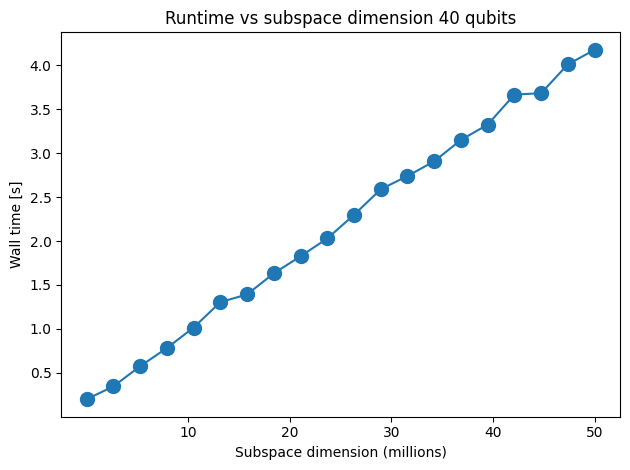

In [4]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = d_list
y1 = time_array

# Plot energies
plt.title("Runtime vs subspace dimension 40 qubits")
plt.xlabel("Subspace dimension (millions)")
plt.ylabel("Wall time [s]")
plt.xticks([1e7, 2e7, 3e7, 4e7, 5e7], [str(i) for i in [10, 20, 30, 40, 50]])
plt.plot(x1, y1, marker=".", markersize=20)
plt.tight_layout()
plt.show()

Let's do the same for 60 qubits

In [5]:
n_qubits = 60
bts_matrix = random_bitstrings(50_000_000, n_qubits)

# We need to sort the bitstrings and just keep the unique ones
bts_matrix = sort_and_remove_duplicates(bts_matrix).astype("bool")

# Final subspace dimension after getting rid of duplicated bitstrings
d = bts_matrix.shape[0]

print("Total number of unique bitstrings: " + str(d))

Total number of unique bitstrings: 50000000


In [6]:
pauli = Pauli("Z" * n_qubits)

# Different subspace sizes to test
d_list = np.linspace(d / 1000, d, 20).astype("int")

# It is better to do this once
row_array = np.arange(d)

# To store the walltime
time_array = np.zeros(20)

for i in range(20):
    int_bts_matrix = bts_matrix[: d_list[i], :]
    int_row_array = row_array[: d_list[i]]
    time_1 = time.time()
    _ = matrix_elements_from_pauli(int_bts_matrix, pauli)
    time_array[i] = time.time() - time_1
    print(f"Iteration {i} took {round(time_array[i], 6)}s")

Iteration 0 took 0.236567s
Iteration 1 took 0.424116s
Iteration 2 took 0.673399s
Iteration 3 took 0.905164s
Iteration 4 took 1.168936s
Iteration 5 took 1.454204s
Iteration 6 took 1.74778s
Iteration 7 took 1.920795s
Iteration 8 took 2.259994s
Iteration 9 took 2.550674s
Iteration 10 took 2.681287s
Iteration 11 took 3.04411s
Iteration 12 took 3.293262s
Iteration 13 took 3.471247s
Iteration 14 took 3.726639s
Iteration 15 took 4.072854s
Iteration 16 took 4.221037s
Iteration 17 took 4.498535s
Iteration 18 took 4.741108s
Iteration 19 took 5.159038s


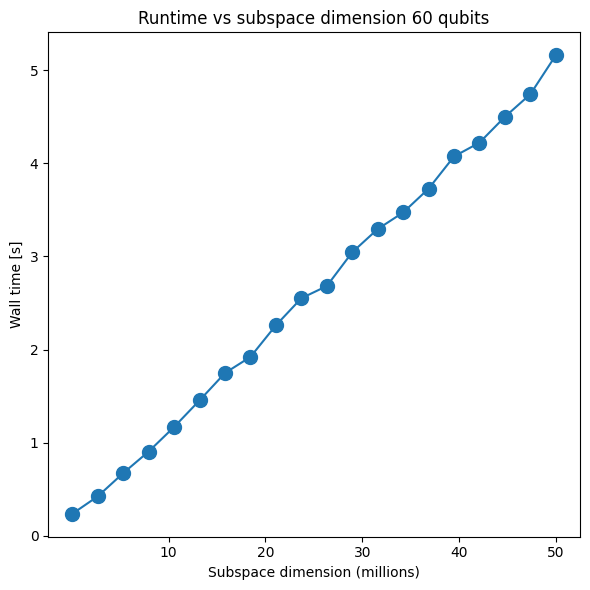

In [7]:
# Data for energies plot
x1 = d_list
y1 = time_array

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

# Plot energies
axs.plot(x1, y1, marker=".", markersize=20)
axs.set_title("Runtime vs subspace dimension 60 qubits")
axs.set_xlabel("Subspace dimension (millions)")
plt.xticks([1e7, 2e7, 3e7, 4e7, 5e7], [str(i) for i in [10, 20, 30, 40, 50]])
axs.set_ylabel("Wall time [s]")

plt.tight_layout()
plt.show()